# Prediction of travel products

## 1. 프로젝트 주제 : 여행 패키지 상품 신청 예측 프로젝트

* 해결하고자 하는 문제 : 여행 패키지상품을 고객이 신청할 지 여부를 예측하고자 한다.  
* 데이터 
    * 데이콘의 고객데이터 (train : 1955개, test : 2933개의 데이터)
    * 선정이유 : 코로나시국 이후로 관광을 많이 못한 사람들의 여행수요가 증가하고 있다. 많은 수요자 중 어떤 고객의 특성이 여행상품을 선택할 지 예측해보고자 한다.   
    * 사용할 Target 특성은 ProdTaken(여행 패키지 신청 여부)로, binary 분류문제이다.

## 2. Import Library and Data

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from category_encoders import OrdinalEncoder

from matplotlib import rcParams

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer # 결측치를 평균으로 대체
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score,roc_curve, roc_auc_score


import seaborn as sns



In [2]:
# seaborn setting
rcParams['figure.figsize'] = 15,8
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 15
colors = sns.color_palette('pastel')

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
0,1,28.0,Company Invited,1,10.0,Small Business,Male,3,4.0,Basic,3.0,Married,3.0,0,1,0,1.0,Executive,20384.0,0
1,2,34.0,Self Enquiry,3,NaN,Small Business,Female,2,4.0,Deluxe,4.0,Single,1.0,1,5,1,0.0,Manager,19599.0,1
2,3,45.0,Company Invited,1,NaN,Salaried,Male,2,3.0,Deluxe,4.0,Married,2.0,0,4,1,0.0,Manager,NaN,0
3,4,29.0,Company Invited,1,7.0,Small Business,Male,3,5.0,Basic,4.0,Married,3.0,0,4,0,1.0,Executive,21274.0,1
4,5,42.0,Self Enquiry,3,6.0,Salaried,Male,2,3.0,Deluxe,3.0,Divorced,2.0,0,3,1,0.0,Manager,19907.0,0


In [4]:
print(train.shape, test.shape)

(1955, 20) (2933, 19)


### 특성 설명(데이콘)

id : 샘플 아이디  
Age : 나이  
TypeofContact : 고객의 제품 인지 방법 (회사의 홍보 or 스스로 검색)  
CityTier : 주거 중인 도시의 등급. (인구, 시설, 생활 수준 기준) (1등급 > 2등급 > 3등급)  
DurationOfPitch : 영업 사원이 고객에게 제공하는 프레젠테이션 기간  
Occupation : 직업  
Gender : 성별  
NumberOfPersonVisiting : 고객과 함께 여행을 계획 중인 총 인원  
NumberOfFollowups : 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수  
ProductPitched : 영업 사원이 제시한 상품  
PreferredPropertyStar : 선호 호텔 숙박업소 등급  
MaritalStatus : 결혼여부  
NumberOfTrips : 평균 연간 여행 횟수  
Passport : 여권 보유 여부 (0: 없음, 1: 있음)  
PitchSatisfactionScore : 영업 사원의 프레젠테이션 만족도  
OwnCar : 자동차 보유 여부 (0: 없음, 1: 있음)  
NumberOfChildrenVisiting : 함께 여행을 계획 중인 5세 미만의 어린이 수  
Designation : (직업의) 직급  
MonthlyIncome : 월 급여  
ProdTaken : 여행 패키지 신청 여부 (0: 신청 안 함, 1: 신청함)  

## 3. 가설, 기준모델(Baseline Model), 평가지표설명

* 가설(탐색적데이터분석)  
    * 가설1 : 결혼 후, 해외여행을 가보지 않은 자녀들이 많을수록 가족패키지에 대한 수요가 있어 패키지신청확률이 높을 것이다.  
    * 가설2 : 영업 사원의 프레젠테이션 만족도는 가족패키지에 대한 수요가 높을 것이다.
    * 가설3 : 여행 패키지를 신청한 사람들의 소득은 2022년 1/4분기 월평균소득인 4,825,000원보다 높을 것이다.  
             (개인별인지 가구별인지 물어보는중임)
    통계청 자료참조.(https://kostat.go.kr/portal/korea/kor_nw/1/1/index.board?bmode=read&aSeq=418357)
    
* 기준모델 및 평가지표설명
    * Baseline Model은 초기 최빈값인 0.20에서 ---으로 변경

## 4. EDA and Data Preprocessing

### 1) EDA
    * Gender 컬럼의 Fe Male->Female로 수정  
    * 결측치제거  

In [5]:
train.info() # 1955*20

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1861 non-null   float64
 2   TypeofContact             1945 non-null   object 
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1853 non-null   float64
 5   Occupation                1955 non-null   object 
 6   Gender                    1955 non-null   object 
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1942 non-null   float64
 9   ProductPitched            1955 non-null   object 
 10  PreferredPropertyStar     1945 non-null   float64
 11  MaritalStatus             1955 non-null   object 
 12  NumberOfTrips             1898 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

In [6]:
test.info() # 2933*19

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2933 non-null   int64  
 1   Age                       2801 non-null   float64
 2   TypeofContact             2918 non-null   object 
 3   CityTier                  2933 non-null   int64  
 4   DurationOfPitch           2784 non-null   float64
 5   Occupation                2933 non-null   object 
 6   Gender                    2933 non-null   object 
 7   NumberOfPersonVisiting    2933 non-null   int64  
 8   NumberOfFollowups         2901 non-null   float64
 9   ProductPitched            2933 non-null   object 
 10  PreferredPropertyStar     2917 non-null   float64
 11  MaritalStatus             2933 non-null   object 
 12  NumberOfTrips             2850 non-null   float64
 13  Passport                  2933 non-null   int64  
 14  PitchSat

In [7]:
# 결측치확인

train.isnull().sum()

id                            0
Age                          94
TypeofContact                10
CityTier                      0
DurationOfPitch             102
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            13
ProductPitched                0
PreferredPropertyStar        10
MaritalStatus                 0
NumberOfTrips                57
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     27
Designation                   0
MonthlyIncome               100
ProdTaken                     0
dtype: int64

In [8]:
'''def preprocessing(df):
    
    # Gender 특성 데이터정리
    df['Gender'] = df['Gender'].str.replace('Fe Male', 'Female')
    
    # 결측치는 SimpleImputer의 최빈값으로 정리해보기로함. 'Age', 'DurationOfPitch', 'NumberOfFollowups', 'NumberOfChildrenVisiting', 'MonthlyIncome'])
    
    # TypeofContact 데이터는 범주형이라 판단하여 결측치 제거(구분이 3개)
    df['TypeofContact'] = df['TypeofContact'].dropna()
    
    # PreferredPropertyStar 데이터는 범주형이라 판단하여 결측치 제거(구분이 3개)
    df['PreferredPropertyStar'] = df['PreferredPropertyStar'].dropna()
    
    # NumberOfChildrenVisiting 데이터는 범주형이라 판단하여 결측치 제거(구분이 4개)
    df['NumberOfChildrenVisiting'] = df['NumberOfChildrenVisiting'].dropna()
    
    # NumberOfTrips
    #df['NumberOfTrips'] = df['NumberOfTrips'] # 얘는 평균이 아니라 median으로 하는게 좋을 듯 (이상치있음)
    return df

'''

"def preprocessing(df):\n    \n    # Gender 특성 데이터정리\n    df['Gender'] = df['Gender'].str.replace('Fe Male', 'Female')\n    \n    # 결측치는 SimpleImputer의 최빈값으로 정리해보기로함. 'Age', 'DurationOfPitch', 'NumberOfFollowups', 'NumberOfChildrenVisiting', 'MonthlyIncome'])\n    \n    # TypeofContact 데이터는 범주형이라 판단하여 결측치 제거(구분이 3개)\n    df['TypeofContact'] = df['TypeofContact'].dropna()\n    \n    # PreferredPropertyStar 데이터는 범주형이라 판단하여 결측치 제거(구분이 3개)\n    df['PreferredPropertyStar'] = df['PreferredPropertyStar'].dropna()\n    \n    # NumberOfChildrenVisiting 데이터는 범주형이라 판단하여 결측치 제거(구분이 4개)\n    df['NumberOfChildrenVisiting'] = df['NumberOfChildrenVisiting'].dropna()\n    \n    # NumberOfTrips\n    #df['NumberOfTrips'] = df['NumberOfTrips'] # 얘는 평균이 아니라 median으로 하는게 좋을 듯 (이상치있음)\n    return df\n\n"

In [9]:
'''data_ = preprocessing(train)
data_.head()'''

'data_ = preprocessing(train)\ndata_.head()'

In [10]:
def data_preprocessing(df):
    
    # Gender 특성 데이터정리
    df['Gender'] = df['Gender'].str.replace('Fe Male', 'Female')
    
    df = df.dropna()
    
    # 나이를 기준으로 나이대별 컬럼생성
    df['Ages'] = (df['Age']//10*10).astype(int)
    
    # 새로운 특성 만들고 난 후 불필요한 컬럼 삭제
    df = df.drop(['Age'],axis=1)
    
    return df


In [11]:
data = data_preprocessing(train)
data.head()

/var/folders/07/192hjwjx7jzfdyz0ph3vff080000gn/T/ipykernel_51082/3317429536.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ages'] = (df['Age']//10*10).astype(int)


,id,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken,Ages
0,1,Company Invited,1,10.0,Small Business,Male,3,4.0,Basic,3.0,Married,3.0,0,1,0,1.0,Executive,20384.0,0,20
3,4,Company Invited,1,7.0,Small Business,Male,3,5.0,Basic,4.0,Married,3.0,0,4,0,1.0,Executive,21274.0,1,20
4,5,Self Enquiry,3,6.0,Salaried,Male,2,3.0,Deluxe,3.0,Divorced,2.0,0,3,1,0.0,Manager,19907.0,0,40
5,6,Self Enquiry,1,29.0,Small Business,Male,4,4.0,Deluxe,3.0,Divorced,3.0,1,5,1,1.0,Manager,24857.0,1,30
6,7,Company Invited,3,8.0,Salaried,Male,3,3.0,Deluxe,3.0,Married,2.0,0,3,1,2.0,Manager,20675.0,0,40


In [12]:
# 테스트데이터도 추후 전처리 해줘야함!!!! 모델링하는거 봐서 더 잘 먹는걸로 전처리하기!

In [13]:
# 컬럼별 데이터내용 확인
data.describe()

,id,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome,ProdTaken,Ages
count,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000
mean,979.323226,1.646452,15.627653,2.970285,3.752577,3.565191,3.316555,0.297150,3.048514,0.610673,1.257732,23141.996968,0.203760,32.510612
std,561.717183,0.912721,8.149520,0.704331,1.017758,0.787972,1.818987,0.457142,1.372873,0.487746,0.853130,4649.463051,0.402915,9.502365
min,1.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000,0.000000,10.000000
25%,492.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,20764.000000,0.000000,30.000000
50%,978.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,1.000000,1.000000,22359.000000,0.000000,30.000000
75%,1465.000000,3.000000,21.000000,3.000000,4.000000,4.000000,4.000000,1.000000,4.000000,1.000000,2.000000,25266.000000,0.000000,40.000000
max,1955.000000,3.000000,36.000000,5.000000,6.000000,5.000000,19.000000,1.000000,5.000000,1.000000,3.000000,98678.000000,1.000000,60.000000


In [14]:
# 컬럼별 데이터 내용 확인
for i in data.columns:
    print(data[i].value_counts())

1       1
1297    1
1308    1
1307    1
1306    1
       ..
655     1
654     1
652     1
651     1
1955    1
Name: id, Length: 1649, dtype: int64
Self Enquiry       1164
Company Invited     485
Name: TypeofContact, dtype: int64
1    1081
3     498
2      70
Name: CityTier, dtype: int64
9.0     171
7.0     114
8.0     105
6.0     102
16.0    100
15.0     96
14.0     94
10.0     88
13.0     80
12.0     78
11.0     71
17.0     66
23.0     39
30.0     36
31.0     33
25.0     31
27.0     31
20.0     29
22.0     29
32.0     28
24.0     25
35.0     24
26.0     23
28.0     23
21.0     22
29.0     22
18.0     22
19.0     18
34.0     17
33.0     16
36.0     14
5.0       2
Name: DurationOfPitch, dtype: int64
Salaried          808
Small Business    693
Large Business    147
Free Lancer         1
Name: Occupation, dtype: int64
Male      1024
Female     625
Name: Gender, dtype: int64
3    851
2    415
4    376
1      6
5      1
Name: NumberOfPersonVisiting, dtype: int64
4.0    729
3.0    436
5.0   

In [15]:
# data_.describe()

## 4. 시각화

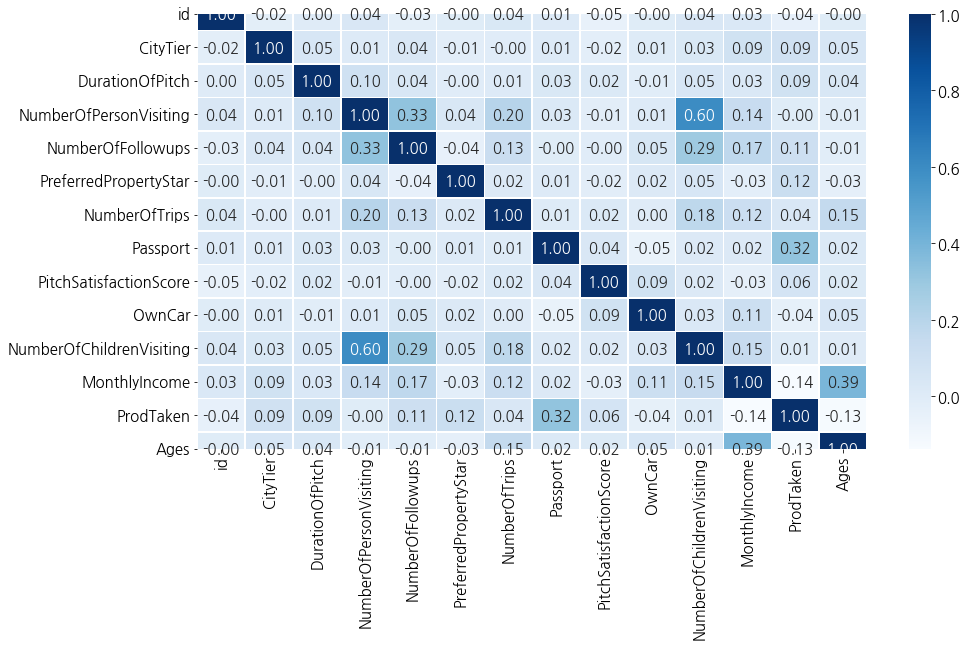

In [16]:
sns.heatmap(data=data.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues');

* 특성간 상관관계가 높을수록 진한색을 띄는데, 데이터를 확인시, 특성간 뚜렷한 상관관계가 보이지 않음을 확인하였다.   


* 타겟인 ProdTaken와 상관관계가 가장 높은 것은 여권소지유무로 0.32가 가장 높은 값이다.  
* 함께 여행을 계획 중인 5세 미만의 어린이 수 고객과 함께 여행을 계획 중인 총 인원은 0.6의 상관관계로 상관관계수치 중 가장 높은 값을 보인다.  


* 타겟의 상관관계가 음수로 나타난 경우  
    * 나이와 타겟의 상관관계 : 이는 고령일수록 패키지여행신청을 하지 않음을 보여준다.  
    * 차량을 미소유한 경우 : 운전을 하지 않는 경우가 패키지여행을 더 고려하는 것을 보여준다.


In [17]:
# 타겟 구성비율확인
print(data['ProdTaken'].value_counts())

print(data['ProdTaken'].value_counts(normalize=True))

0    1313
1     336
Name: ProdTaken, dtype: int64
0    0.79624
1    0.20376
Name: ProdTaken, dtype: float64


/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


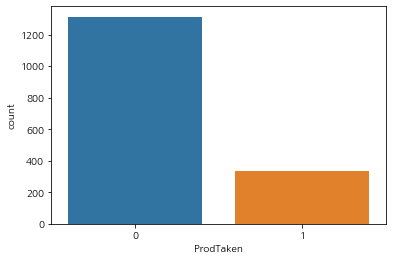

In [18]:
# 타겟의 imbalance 확인
%matplotlib inline

sns.countplot(data['ProdTaken']);

In [19]:
# ProdTaken이 1로 나온 특성별 분포확인(여행패키지 신청한 경우)

dataa = data[data['ProdTaken']==1]
dataa.shape

(336, 20)

/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotl

/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotl

/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


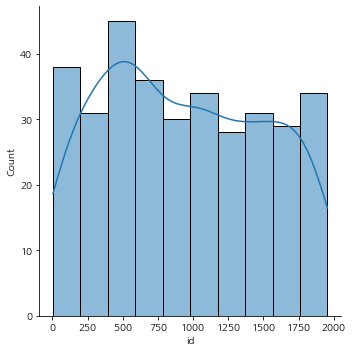

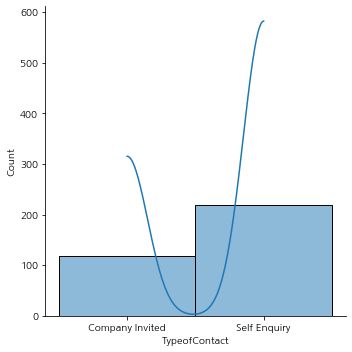

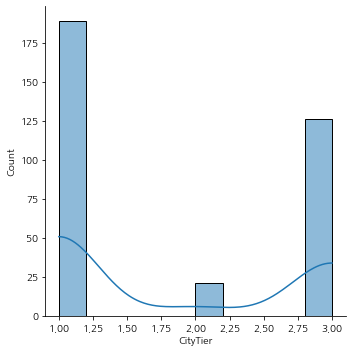

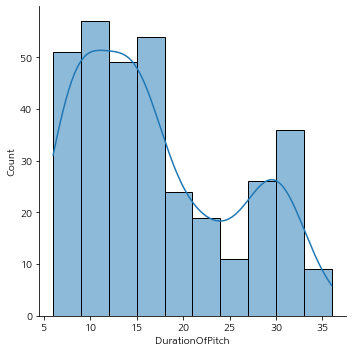

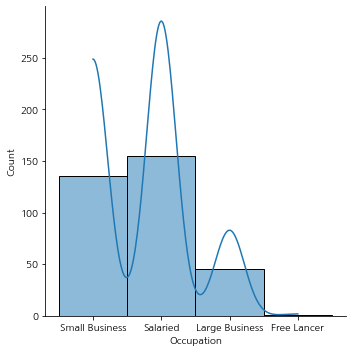

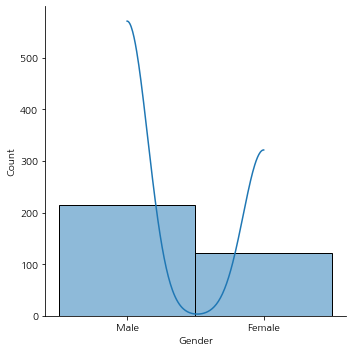

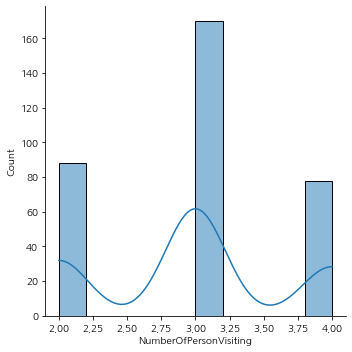

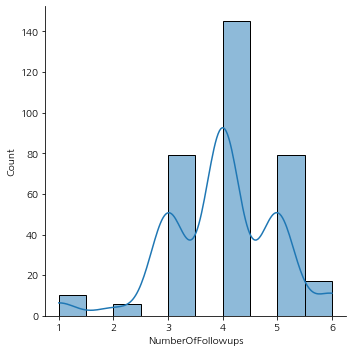

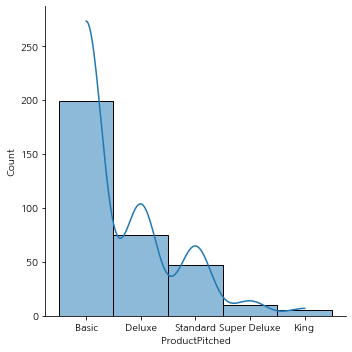

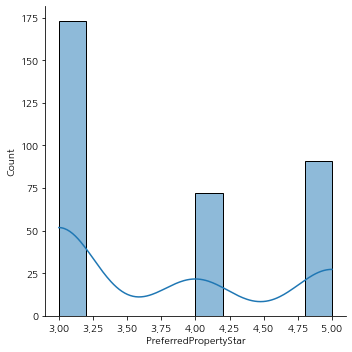

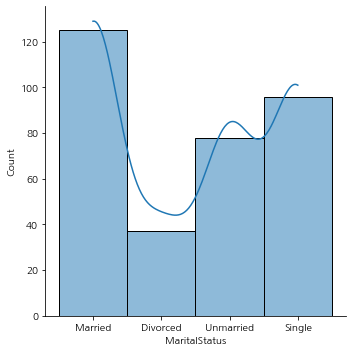

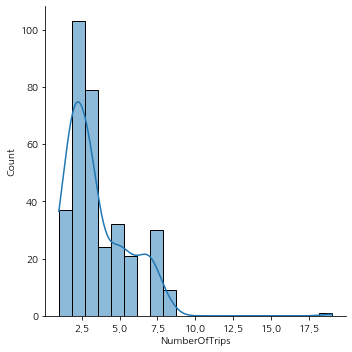

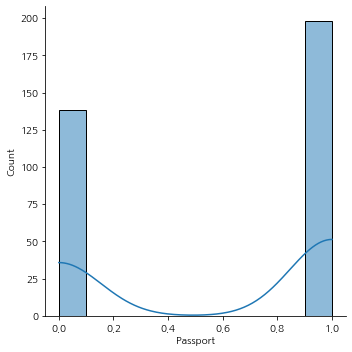

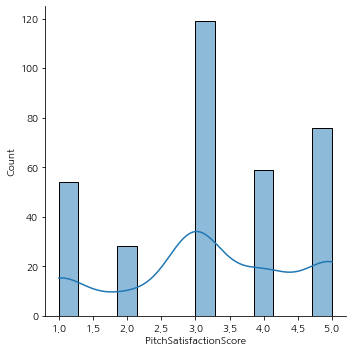

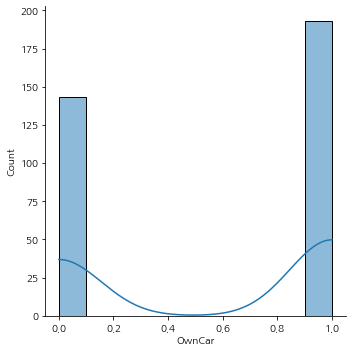

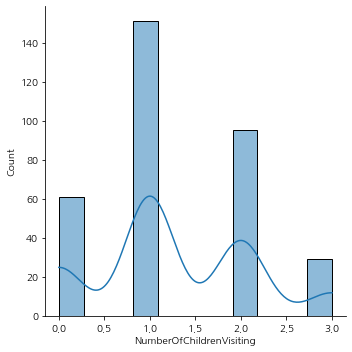

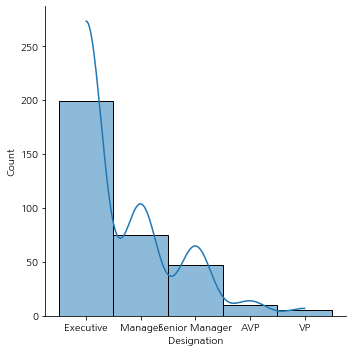

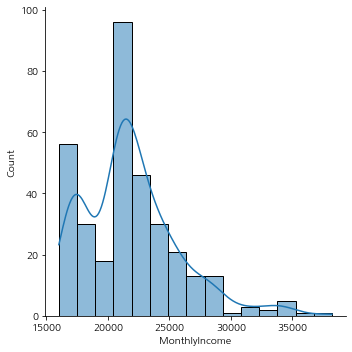

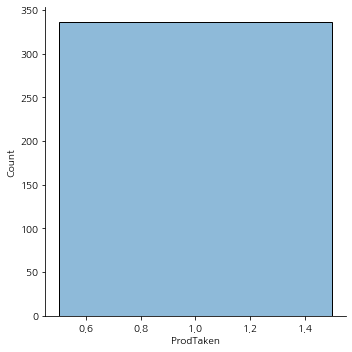

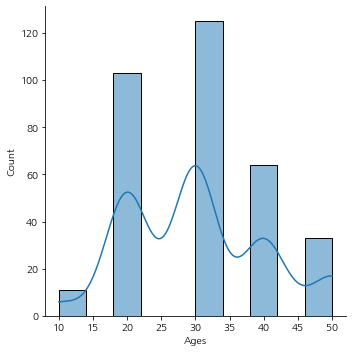

In [20]:
for i in dataa.columns:
    sns.displot(dataa[i],kde=True) # kde : 커널밀도추정. 커널함수와 데이터를 바탕으로 연속성있는 확률밀도함수를 추정하는것.

In [21]:
data['Occupation'].value_counts()

Salaried          808
Small Business    693
Large Business    147
Free Lancer         1
Name: Occupation, dtype: int64

In [22]:
# could not convert string to float: 'Company Invited' 이런 에러가 떠서 했었음.
# data['Occupation'] = data['Occupation'].str.strip()

/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotl

/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotl

/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hun/opt/anaconda3/envs/kerneljookjima/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


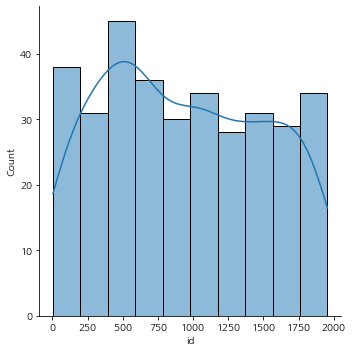

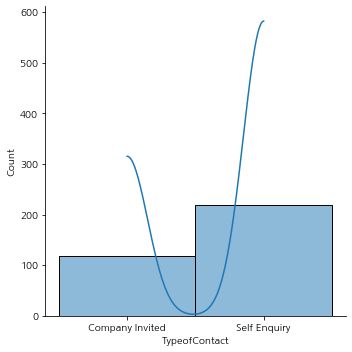

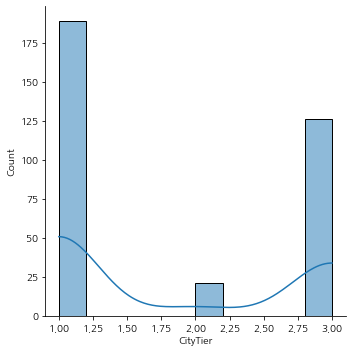

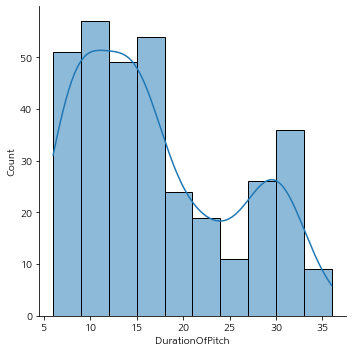

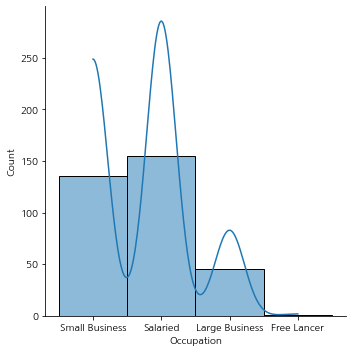

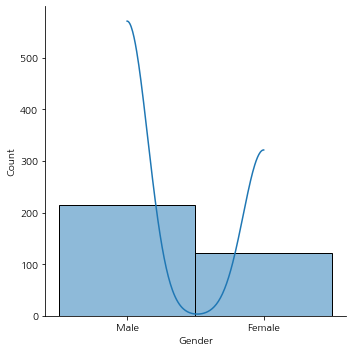

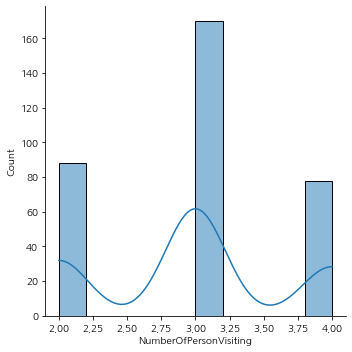

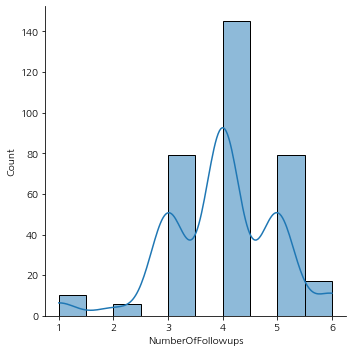

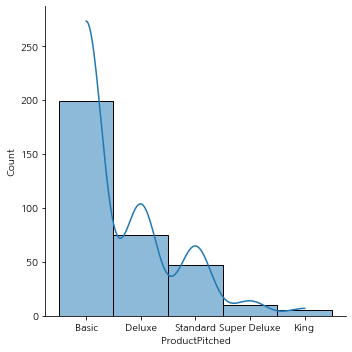

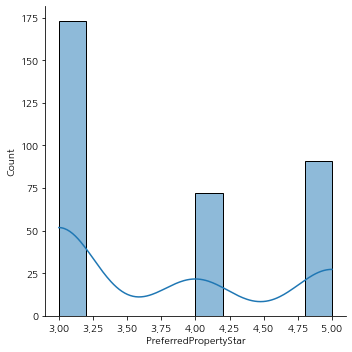

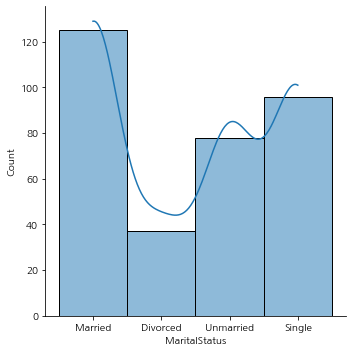

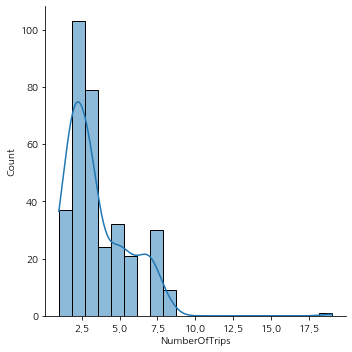

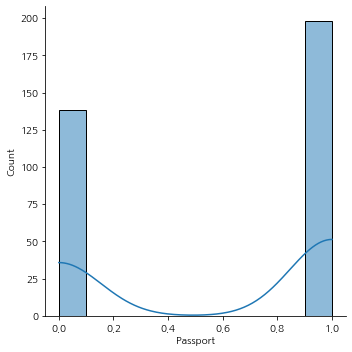

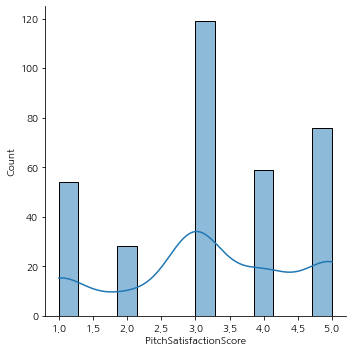

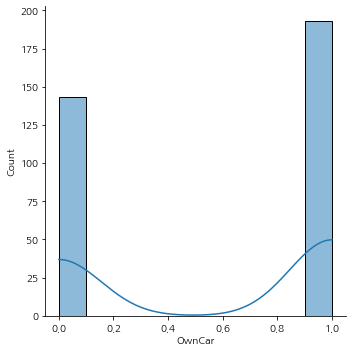

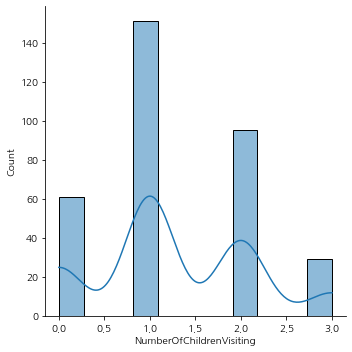

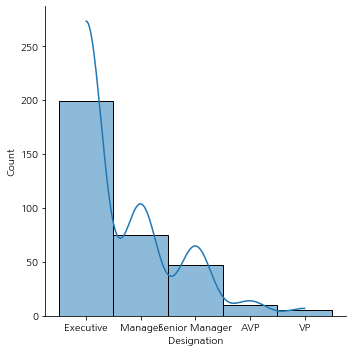

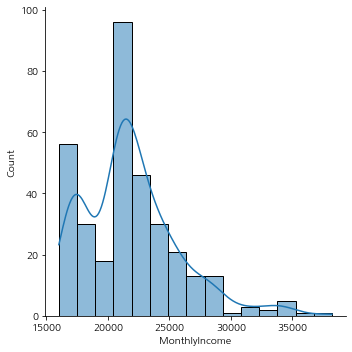

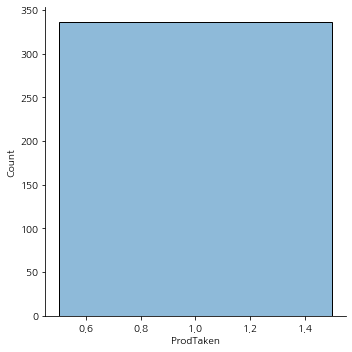

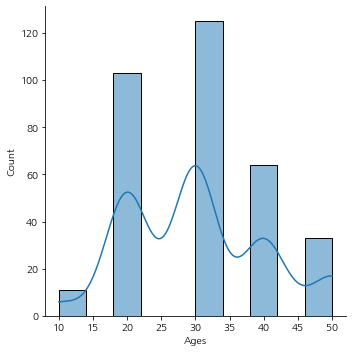

In [23]:
for i in dataa.columns:
    sns.displot(dataa[i],kde=True) # kde : 커널밀도추정. 커널함수와 데이터를 바탕으로 연속성있는 확률밀도함수를 추정하는것.

In [24]:
def plot_counts(dataframe):
    dataframe['ProdTaken'].value_counts()
    sns.countplot(data=dataframe, x='ProdTaken')

In [25]:
data.columns

Index(['id', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'Occupation',
       'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Ages'],
      dtype='object')

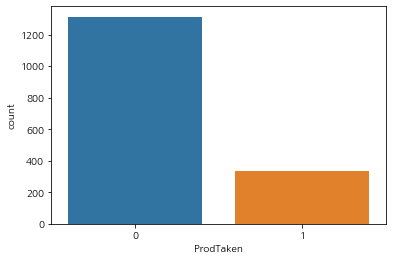

In [26]:
sns.countplot(data=data,x='ProdTaken')

Text(0.5, 1.0, '패키지 미선택한 성 비율')

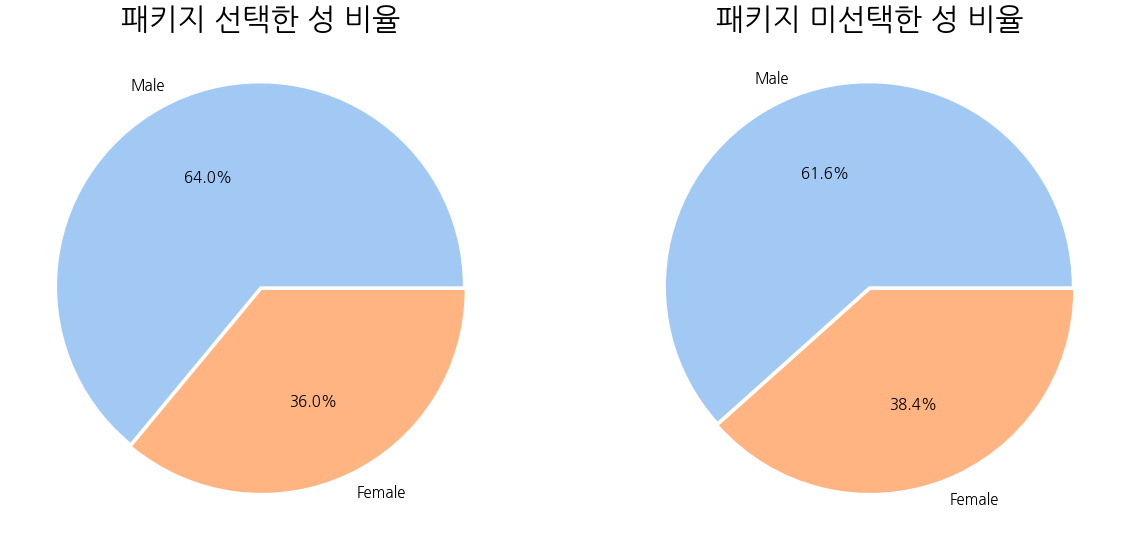

In [27]:
# 패키지 선택한 성 비율
yes = data[data.ProdTaken==1]

# 패키지 미선택한 성비율 
no = data[data.ProdTaken==0]

# 한번에 piechart 2개 보여주기
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to your two pies
# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1


pie_data=yes['Gender'].value_counts()
labels=yes['Gender'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)

ax1.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot first pie
ax1.set_title('패키지 선택한 성 비율',fontsize=30)


pie_data=no['Gender'].value_counts()
labels=no['Gender'].value_counts().index
ax2.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot second pie
ax2.set_title('패키지 미선택한 성 비율',fontsize=30)


Text(0.5, 1.0, '패키지 미선택한 직업군 비율')

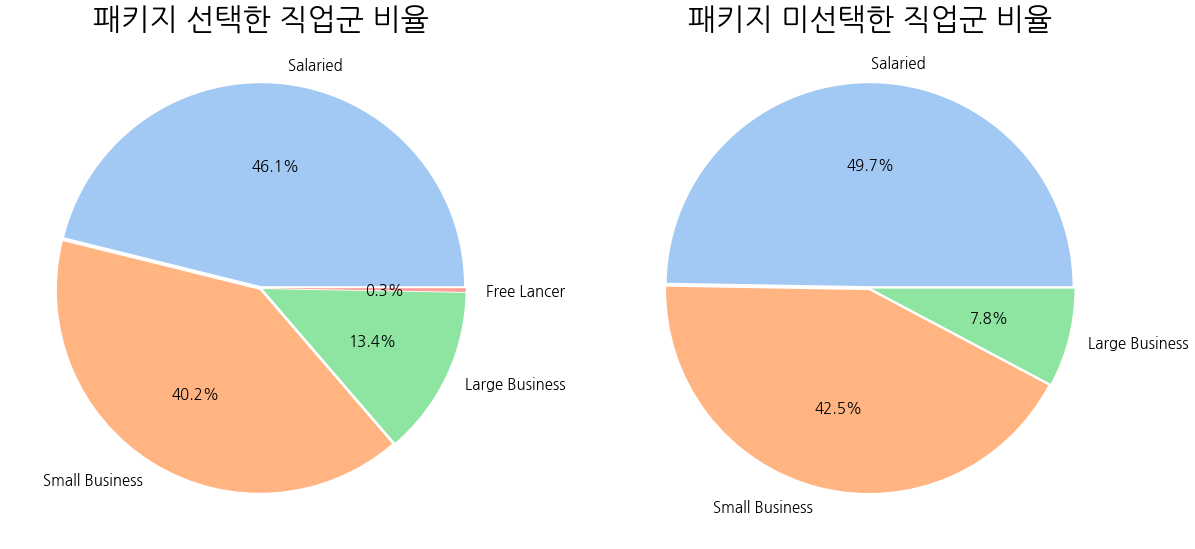

In [28]:
# 한번에 piechart 2개 보여주기
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to your two pies
# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1

pie_data=yes['Occupation'].value_counts()
labels=yes['Occupation'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)

ax1.pie(pie_data,labels = labels,colors = colors,explode=explode, autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot first pie
ax1.set_title('패키지 선택한 직업군 비율',fontsize=30)


pie_data=no['Occupation'].value_counts()
labels=no['Occupation'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)

ax2.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot second pie
ax2.set_title('패키지 미선택한 직업군 비율',fontsize=30)


In [44]:
data[data['Occupation']=='Salaried']

,id,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken,Ages
4,5,Self Enquiry,3,6.0,Salaried,Male,2,3.0,Deluxe,3.0,Divorced,2.0,0,3,1,0.0,Manager,19907.0,0,40
6,7,Company Invited,3,8.0,Salaried,Male,3,3.0,Deluxe,3.0,Married,2.0,0,3,1,2.0,Manager,20675.0,0,40
9,10,Self Enquiry,1,7.0,Salaried,Male,4,4.0,Basic,3.0,Unmarried,3.0,1,3,1,1.0,Executive,21364.0,1,30
10,11,Company Invited,1,14.0,Salaried,Male,4,6.0,Deluxe,3.0,Unmarried,3.0,1,5,1,1.0,Manager,24752.0,1,30
18,19,Self Enquiry,1,8.0,Salaried,Female,3,3.0,Basic,3.0,Married,5.0,0,5,1,0.0,Executive,17543.0,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943,1944,Self Enquiry,1,14.0,Salaried,Female,2,4.0,Basic,4.0,Single,2.0,0,4,0,1.0,Executive,17154.0,1,20
1945,1946,Self Enquiry,3,12.0,Salaried,Female,3,3.0,Standard,3.0,Single,4.0,1,1,0,0.0,Senior Manager,28591.0,0,40
1949,1950,Self Enquiry,1,15.0,Salaried,Female,3,4.0,Basic,5.0,Divorced,2.0,0,1,1,2.0,Executive,21628.0,0,50
1951,1952,Self Enquiry,3,8.0,Salaried,Female,3,3.0,Super Deluxe,5.0,Divorced,1.0,0,5,1,1.0,AVP,31595.0,0,40


Text(0.5, 1.0, '패키지 미선택한 고객의 제품인지방법 비율')

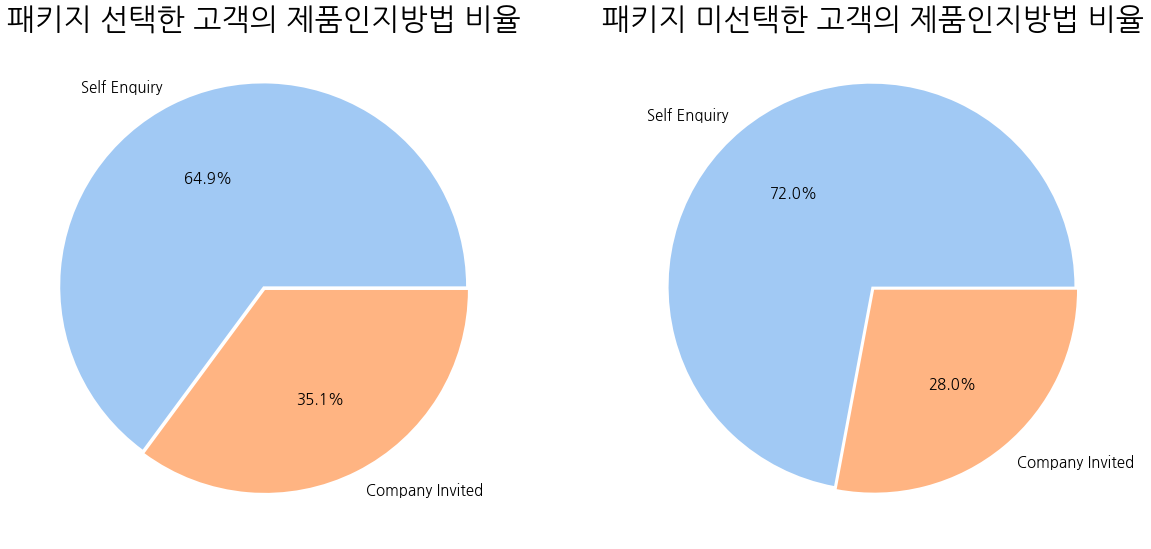

In [29]:
# 한번에 piechart 2개 보여주기
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to your two pies
# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1

pie_data=yes['TypeofContact'].value_counts()
labels=yes['TypeofContact'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)
    
ax1.pie(pie_data,labels = labels,colors = colors,explode=explode, autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot first pie
ax1.set_title('패키지 선택한 고객의 제품인지방법 비율',fontsize=30)


pie_data=no['TypeofContact'].value_counts()
labels=no['TypeofContact'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)

ax2.pie(pie_data,labels = labels,colors = colors,explode=explode, autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot second pie
ax2.set_title('패키지 미선택한 고객의 제품인지방법 비율',fontsize=30)


Text(0.5, 1.0, '패키지 미선택한 직업군 비율')

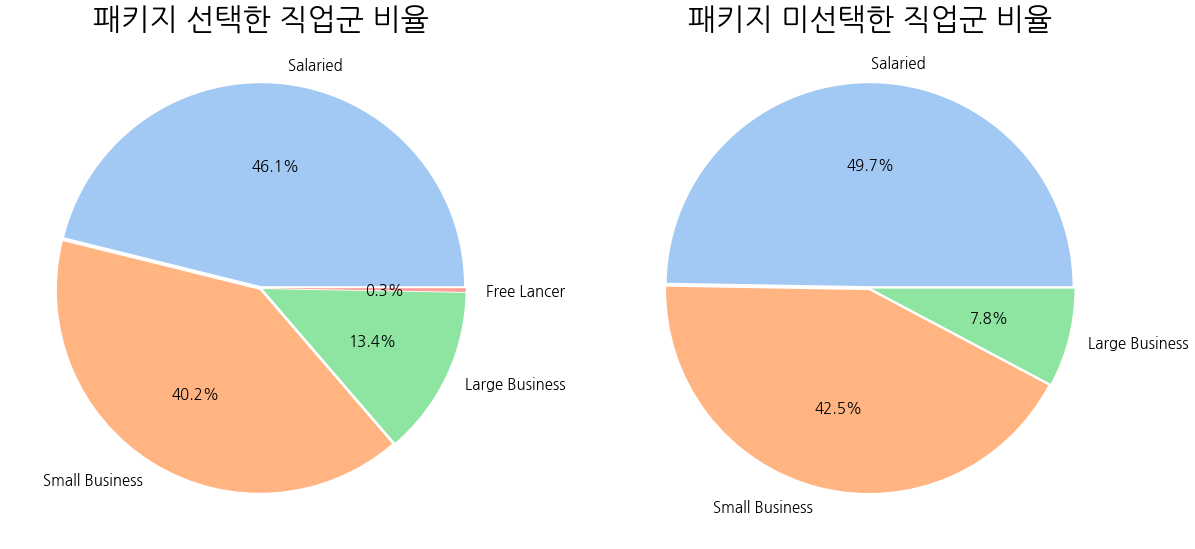

In [30]:
# 한번에 piechart 2개 보여주기
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to your two pies
# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1

pie_data=yes['Occupation'].value_counts()
labels=yes['Occupation'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)
    
ax1.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot first pie
ax1.set_title('패키지 선택한 직업군 비율',fontsize=30)


pie_data=no['Occupation'].value_counts()
labels=no['Occupation'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)
    
ax2.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot second pie
ax2.set_title('패키지 미선택한 직업군 비율',fontsize=30)


프리랜서는 한 명인데, 직함은 Executive로 해 둔 것으로 보아 사외이사로 간주하자.

Text(0.5, 1.0, '패키지 미선택한 성 비율')

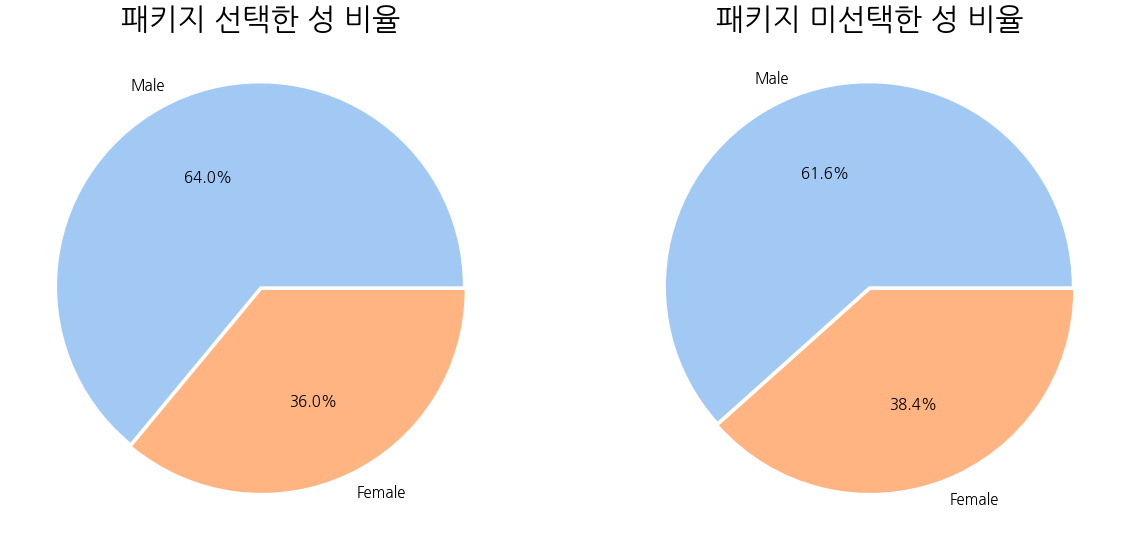

In [31]:
# 패키지 선택한 성 비율
yes = data[data.ProdTaken==1]

# 패키지 미선택한 성비율 
no = data[data.ProdTaken==0]

# 한번에 piechart 2개 보여주기
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to your two pies
# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1

pie_data=yes['Gender'].value_counts()
labels=yes['Gender'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)
    

ax1.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot first pie
ax1.set_title('패키지 선택한 성 비율',fontsize=30)


pie_data=no['Gender'].value_counts()
labels=no['Gender'].value_counts().index
ax2.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot second pie
ax2.set_title('패키지 미선택한 성 비율',fontsize=30)


Text(0.5, 1.0, '패키지 미선택한 영업사원상품제시 비율')

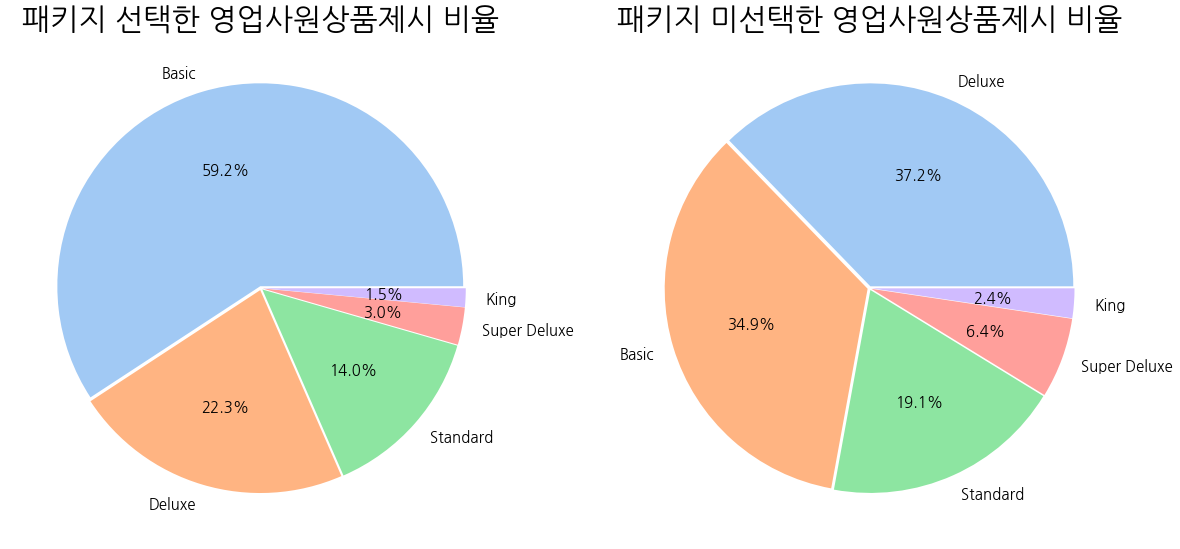

In [32]:
# 한번에 piechart 2개 보여주기
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to your two pies
# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1

pie_data=yes['ProductPitched'].value_counts()
labels=yes['ProductPitched'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)

ax1.pie(pie_data,labels = labels,colors = colors,explode=explode, autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot first pie
ax1.set_title('패키지 선택한 영업사원상품제시 비율',fontsize=30)


pie_data=no['ProductPitched'].value_counts()
labels=no['ProductPitched'].value_counts().index
ax2.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot second pie
ax2.set_title('패키지 미선택한 영업사원상품제시 비율',fontsize=30)


Text(0.5, 1.0, '패키지 미선택한 결혼여부 비율')

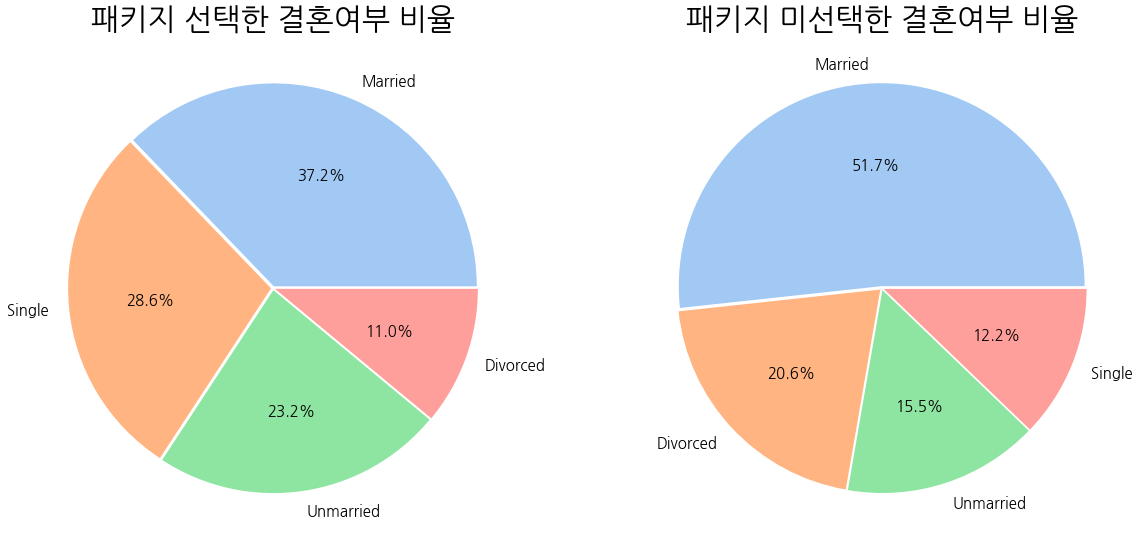

In [33]:
# 한번에 piechart 2개 보여주기
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to your two pies
# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1

pie_data=yes['MaritalStatus'].value_counts()
labels=yes['MaritalStatus'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)
    
ax1.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot first pie
ax1.set_title('패키지 선택한 결혼여부 비율',fontsize=30)


pie_data=no['MaritalStatus'].value_counts()
labels=no['MaritalStatus'].value_counts().index
ax2.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot second pie
ax2.set_title('패키지 미선택한 결혼여부 비율',fontsize=30)


Text(0.5, 1.0, '패키지 미선택한 직급 비율')

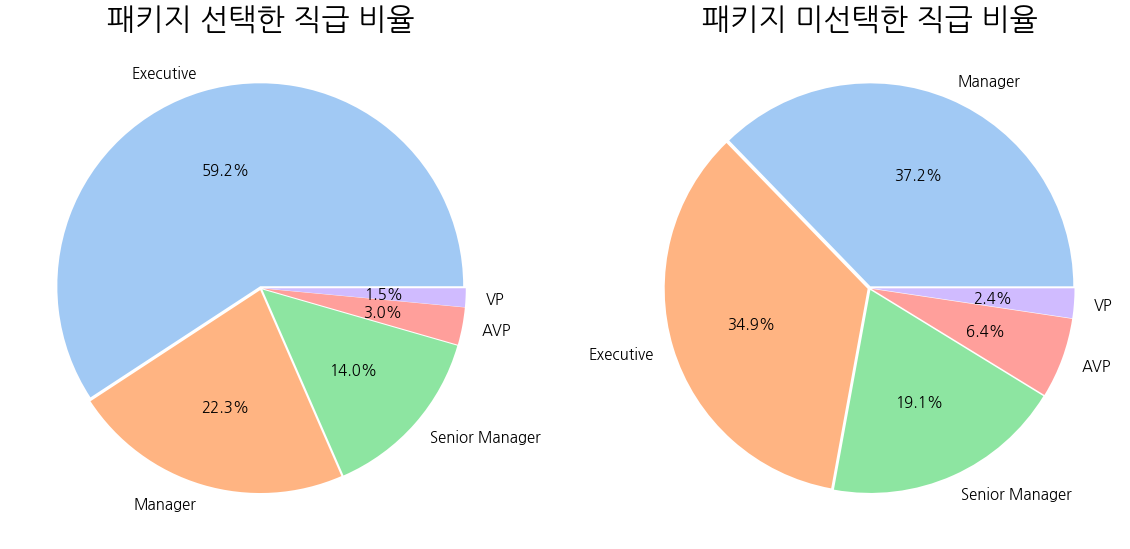

In [34]:
# 한번에 piechart 2개 보여주기
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to your two pies
# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1

pie_data=yes['Designation'].value_counts()
labels=yes['Designation'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)
    
ax1.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot first pie
ax1.set_title('패키지 선택한 직급 비율',fontsize=30)


pie_data=no['Designation'].value_counts()
labels=no['Designation'].value_counts().index
ax2.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot second pie
ax2.set_title('패키지 미선택한 직급 비율',fontsize=30)


직함에 매니저라고 적어도 직업에 작은 사업, 큰 사업으로 기재된 경우가 많아, 직함은 큰 의미가 없는 것으로 파악하기로 한다.
(기업의 규모마다 매니저의 역할/역량이 다른 경우도 많으니 큰 의미를 두지 않기로 하며, 매니저 이상의 고객군으로 파악하기로 한다.)

In [35]:
# 매니저 직함의 직업 종류 분포
aa = data[data['Designation']=='Manager']
aa['Occupation'].value_counts()

Salaried          265
Small Business    256
Large Business     43
Name: Occupation, dtype: int64

In [36]:
# 경영진 직함의 직업 종류 분포
bb = data[data['Designation']=='Executive']
bb['Occupation'].value_counts()

Salaried          344
Small Business    248
Large Business     64
Free Lancer         1
Name: Occupation, dtype: int64

Text(0.5, 1.0, '패키지 미선택한 연령대 비율')

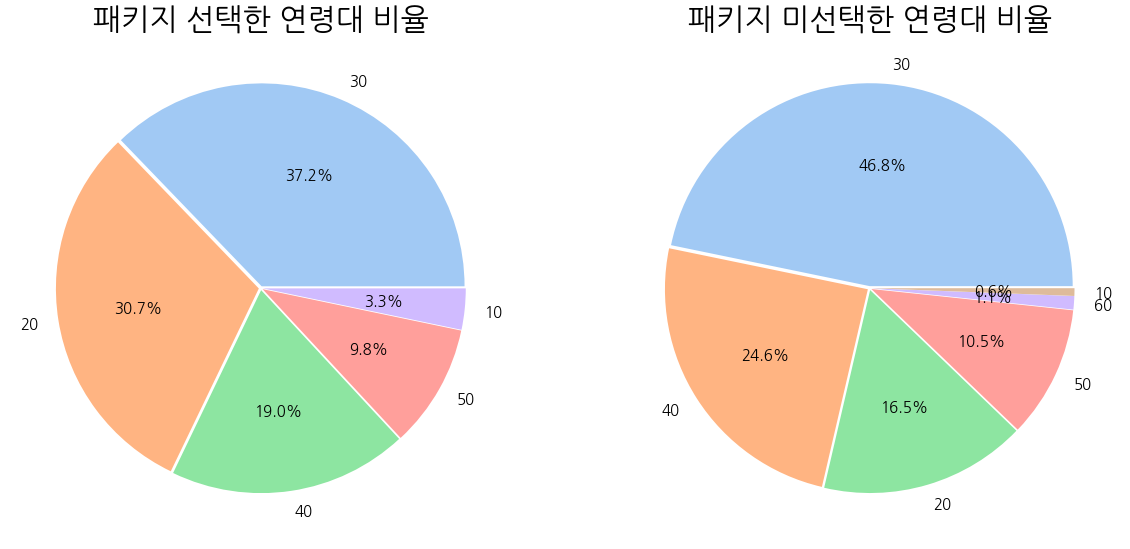

In [37]:
# 한번에 piechart 2개 보여주기
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20)) #ax1,ax2 refer to your two pies
# 1,2 denotes 1 row, 2 columns - if you want to stack vertically, it would be 2,1

pie_data=yes['Ages'].value_counts()
labels=yes['Ages'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)
    
ax1.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot first pie
ax1.set_title('패키지 선택한 연령대 비율',fontsize=30)


pie_data=no['Ages'].value_counts()
labels=no['Ages'].value_counts().index

explode = []
for i in range(len(labels)):
    explode.append(0.01)
    
ax2.pie(pie_data,labels = labels,colors = colors,explode=explode,autopct = '%1.1f%%', textprops={'fontsize': 15}) #plot second pie
ax2.set_title('패키지 미선택한 연령대 비율',fontsize=30)


## 5. Modeling

### 모델의 유용성과 한계

* 목적 : 주어진 특성을 분석하여 패키지 여행을 신청할 지, 말 지 예측
* 유용성 : 잠재고객을 파악하여 영업/광고방향 설정 가능
* 한계 : 
    

## 데이터에서 직급은 삭제할까...!! 

In [38]:
# 훈련/검증셋 나누기

train, val = train_test_split(data, test_size=0.2, random_state=2)

target = 'ProdTaken'
features = data.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

train.shape, val.shape, test.shape

((1319, 20), (330, 20), (2933, 19))

In [39]:
# randomforest_ordinal encoding

pipe_rf_o = make_pipeline(
    OrdinalEncoder(), # 범주형 자료를 모델링할 때는 원핫보다 오디널이 좋음! 중요한 노드가 상위에서 선택되어야하는데 원핫을하면 적용이 잘 안됨! 한가지 특성이 여러가지로 나눠지기 때문에! 그래서 노미널인코딩이라도 오디널을 사용함! 트리에서는 순서가 상관없어서 괜찮다!
    RandomForestClassifier())

pipe_rf_o.fit(X_train, y_train)
y_pred = pipe_rf_o.predict(X_val)

print('훈련 정확도', pipe_rf_o.score(X_train,y_train))
print('검증 정확도', pipe_rf_o.score(X_val, y_val))
print('F1 score', f1_score(y_val, y_pred))
print('AUC 점수 :', roc_auc_score(y_val, y_pred))
print('REPORT',classification_report(y_val,y_pred))

훈련 정확도 1.0
검증 정확도 0.8393939393939394
F1 score 0.5309734513274336
AUC 점수 : 0.6823870573870573
REPORT               precision    recall  f1-score   support

           0       0.84      0.98      0.90       252
           1       0.86      0.38      0.53        78

    accuracy                           0.84       330
   macro avg       0.85      0.68      0.72       330
weighted avg       0.84      0.84      0.82       330



In [40]:
# catboost, ordinalencoder

pipe_cat_o = make_pipeline(
    OrdinalEncoder(), # 범주형 자료를 모델링할 때는 원핫보다 오디널이 좋음! 중요한 노드가 상위에서 선택되어야하는데 원핫을하면 적용이 잘 안됨! 한가지 특성이 여러가지로 나눠지기 때문에! 그래서 노미널인코딩이라도 오디널을 사용함! 트리에서는 순서가 상관없어서 괜찮다!
    CatBoostClassifier())

pipe_cat_o.fit(X_train, y_train)
y_pred = pipe_cat_o.predict(X_val)

print('훈련 정확도', pipe_cat_o.score(X_train,y_train))
print('검증 정확도', pipe_cat_o.score(X_val, y_val))
print('F1 score', f1_score(y_val, y_pred))
print('AUC 점수 :', roc_auc_score(y_val, y_pred))
print('REPORT',classification_report(y_val, y_pred))

Learning rate set to 0.011595
0:	learn: 0.6852569	total: 54.7ms	remaining: 54.7s
1:	learn: 0.6802589	total: 56.2ms	remaining: 28.1s
2:	learn: 0.6727583	total: 57.8ms	remaining: 19.2s
3:	learn: 0.6655501	total: 59.1ms	remaining: 14.7s
4:	learn: 0.6591908	total: 60.1ms	remaining: 12s
5:	learn: 0.6512863	total: 61.1ms	remaining: 10.1s
6:	learn: 0.6448650	total: 62ms	remaining: 8.79s
7:	learn: 0.6384359	total: 63ms	remaining: 7.81s
8:	learn: 0.6321327	total: 63.9ms	remaining: 7.03s
9:	learn: 0.6261674	total: 64.7ms	remaining: 6.41s
10:	learn: 0.6194630	total: 65.5ms	remaining: 5.89s
11:	learn: 0.6128978	total: 66.4ms	remaining: 5.46s
12:	learn: 0.6084642	total: 67.3ms	remaining: 5.11s
13:	learn: 0.6033849	total: 68.3ms	remaining: 4.81s
14:	learn: 0.5993674	total: 69.1ms	remaining: 4.54s
15:	learn: 0.5941650	total: 69.9ms	remaining: 4.3s
16:	learn: 0.5885988	total: 70.7ms	remaining: 4.09s
17:	learn: 0.5827798	total: 71.4ms	remaining: 3.9s
18:	learn: 0.5778175	total: 72.1ms	remaining: 3.72s


175:	learn: 0.3269576	total: 187ms	remaining: 875ms
176:	learn: 0.3263935	total: 188ms	remaining: 873ms
177:	learn: 0.3257986	total: 188ms	remaining: 870ms
178:	learn: 0.3252728	total: 189ms	remaining: 868ms
179:	learn: 0.3248824	total: 190ms	remaining: 865ms
180:	learn: 0.3245229	total: 191ms	remaining: 863ms
181:	learn: 0.3241094	total: 191ms	remaining: 861ms
182:	learn: 0.3236963	total: 192ms	remaining: 858ms
183:	learn: 0.3234437	total: 193ms	remaining: 856ms
184:	learn: 0.3229513	total: 194ms	remaining: 853ms
185:	learn: 0.3226178	total: 194ms	remaining: 851ms
186:	learn: 0.3221792	total: 195ms	remaining: 849ms
187:	learn: 0.3212884	total: 196ms	remaining: 846ms
188:	learn: 0.3208783	total: 197ms	remaining: 844ms
189:	learn: 0.3204383	total: 198ms	remaining: 842ms
190:	learn: 0.3200079	total: 198ms	remaining: 840ms
191:	learn: 0.3195011	total: 199ms	remaining: 839ms
192:	learn: 0.3192175	total: 200ms	remaining: 836ms
193:	learn: 0.3187648	total: 201ms	remaining: 834ms
194:	learn: 

360:	learn: 0.2538779	total: 323ms	remaining: 571ms
361:	learn: 0.2537227	total: 324ms	remaining: 571ms
362:	learn: 0.2529676	total: 325ms	remaining: 570ms
363:	learn: 0.2524590	total: 326ms	remaining: 569ms
364:	learn: 0.2522018	total: 326ms	remaining: 568ms
365:	learn: 0.2520140	total: 327ms	remaining: 567ms
366:	learn: 0.2517781	total: 328ms	remaining: 566ms
367:	learn: 0.2513989	total: 329ms	remaining: 564ms
368:	learn: 0.2511005	total: 329ms	remaining: 563ms
369:	learn: 0.2507472	total: 330ms	remaining: 562ms
370:	learn: 0.2504633	total: 331ms	remaining: 561ms
371:	learn: 0.2502425	total: 332ms	remaining: 560ms
372:	learn: 0.2500868	total: 332ms	remaining: 559ms
373:	learn: 0.2498582	total: 333ms	remaining: 558ms
374:	learn: 0.2496322	total: 334ms	remaining: 557ms
375:	learn: 0.2494115	total: 335ms	remaining: 556ms
376:	learn: 0.2492856	total: 336ms	remaining: 555ms
377:	learn: 0.2489588	total: 337ms	remaining: 554ms
378:	learn: 0.2487919	total: 338ms	remaining: 553ms
379:	learn: 

582:	learn: 0.1998032	total: 509ms	remaining: 364ms
583:	learn: 0.1995814	total: 510ms	remaining: 363ms
584:	learn: 0.1993801	total: 511ms	remaining: 363ms
585:	learn: 0.1991635	total: 512ms	remaining: 362ms
586:	learn: 0.1990716	total: 513ms	remaining: 361ms
587:	learn: 0.1989361	total: 514ms	remaining: 360ms
588:	learn: 0.1987950	total: 515ms	remaining: 360ms
589:	learn: 0.1986910	total: 516ms	remaining: 359ms
590:	learn: 0.1984183	total: 517ms	remaining: 358ms
591:	learn: 0.1981166	total: 519ms	remaining: 357ms
592:	learn: 0.1978300	total: 520ms	remaining: 357ms
593:	learn: 0.1977953	total: 521ms	remaining: 356ms
594:	learn: 0.1977397	total: 522ms	remaining: 355ms
595:	learn: 0.1975456	total: 523ms	remaining: 354ms
596:	learn: 0.1971912	total: 524ms	remaining: 354ms
597:	learn: 0.1969919	total: 525ms	remaining: 353ms
598:	learn: 0.1967159	total: 526ms	remaining: 352ms
599:	learn: 0.1964884	total: 527ms	remaining: 351ms
600:	learn: 0.1963501	total: 528ms	remaining: 350ms
601:	learn: 

835:	learn: 0.1593683	total: 694ms	remaining: 136ms
836:	learn: 0.1591905	total: 695ms	remaining: 135ms
837:	learn: 0.1590846	total: 695ms	remaining: 134ms
838:	learn: 0.1590310	total: 696ms	remaining: 134ms
839:	learn: 0.1589380	total: 697ms	remaining: 133ms
840:	learn: 0.1587665	total: 698ms	remaining: 132ms
841:	learn: 0.1586484	total: 699ms	remaining: 131ms
842:	learn: 0.1585471	total: 699ms	remaining: 130ms
843:	learn: 0.1583153	total: 700ms	remaining: 129ms
844:	learn: 0.1580976	total: 701ms	remaining: 129ms
845:	learn: 0.1579262	total: 702ms	remaining: 128ms
846:	learn: 0.1578090	total: 702ms	remaining: 127ms
847:	learn: 0.1575422	total: 703ms	remaining: 126ms
848:	learn: 0.1573668	total: 704ms	remaining: 125ms
849:	learn: 0.1571812	total: 705ms	remaining: 124ms
850:	learn: 0.1571316	total: 706ms	remaining: 124ms
851:	learn: 0.1569482	total: 706ms	remaining: 123ms
852:	learn: 0.1568659	total: 707ms	remaining: 122ms
853:	learn: 0.1567274	total: 708ms	remaining: 121ms
854:	learn: 

In [41]:
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression

In [42]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'most_frequent')

X_train_imputer = imputer.fit_transform(X_train_data)
X_val_imputer = imputer.transform(X_val_data)

NameError: name 'X_train_data' is not defined

In [ ]:
# catboost, ordinalencoder

pipe_cat_o = make_pipeline(
    OrdinalEncoder(), # 범주형 자료를 모델링할 때는 원핫보다 오디널이 좋음! 중요한 노드가 상위에서 선택되어야하는데 원핫을하면 적용이 잘 안됨! 한가지 특성이 여러가지로 나눠지기 때문에! 그래서 노미널인코딩이라도 오디널을 사용함! 트리에서는 순서ㅁ가 상관없어서 괜찮다!
    LogisticRegression())

pipe_cat_o.fit(X_train, y_train)
y_pred = pipe_cat_o.predict(X_val)

print('훈련 정확도', pipe_cat_o.score(X_train,y_train))
print('검증 정확도', pipe_cat_o.score(X_val, y_val))
print('F1 score', f1_score(y_val, y_pred))
print('AUC 점수 :', roc_auc_score(y_val, y_pred))
print('REPORT',classification_report(y_val, y_pred))

### 1. Logistic Regression 

### 2. RandomForest

### 3. XGBoost

### 4. CatBoost